# Initalization for object tracking by the use of object detection

Disclaimer: This notebook is built upon the code provided by The AI guy on Youtube: https://www.youtube.com/channel/UCrydcKaojc44XnuXrfhlV8Q

In [2]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time
import os
from PIL import Image
from google.colab.patches import cv2_imshow
import torch
from types import FrameType

In [3]:
# cloning yolov5 library and installing requirements
!git clone https://github.com/ultralytics/yolov5  # clone
%cd yolov5
%pip install -qr requirements.txt  # install

Cloning into 'yolov5'...
remote: Enumerating objects: 13003, done.
remote: Total 13003 (delta 0), reused 0 (delta 0), pack-reused 13003
Receiving objects: 100% (13003/13003), 11.86 MiB | 26.52 MiB/s, done.
Resolving deltas: 100% (9037/9037), done.
/content/yolov5
     |████████████████████████████████| 596 kB 5.3 MB/s 


In [4]:
from yolov5 import utils
display = utils.notebook_init()  # checks

YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.6/107.7 GB disk)


In [5]:
# connecting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Helper Functions
Below are a few helper function to make converting between different image data types and formats. From The AI guy.

In [6]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

##Yolov5 object detector
This notebook uses the YOLOv5 object detection model to detect objects in real-time. The code for the yolov5 can be found here: https://github.com/ultralytics/yolov5

In [7]:
# loading the model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')
#only using human and bottle classes
model.classes=[0,39]

Downloading: "https://github.com/ultralytics/yolov5/archive/master.zip" to /root/.cache/torch/hub/master.zip
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CPU



  0%|          | 0.00/14.1M [00:00<?, ?B/s]


Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 


## Webcam Images
Using Google Colab's **Code Snippets** to access webcam.

Code is copied from The AI Guy.

In [8]:
def take_photo(filename='photo.jpg', quality=0.8):
  # Javascript code for images
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display.display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)[..., ::-1]

  # running object detection on the image
  results = model(img)
  results.show()
  # formatting image for opencv
  img = results.imgs[0][..., ::-1]


  # extracting the labels and boundary boxes from the model
  labels, cord_thres = results.xyxyn[0][:, -1].cpu().numpy(), results.xyxyn[0][:, :-1].cpu().numpy()

  return img, labels, cord_thres

<IPython.core.display.Javascript object>

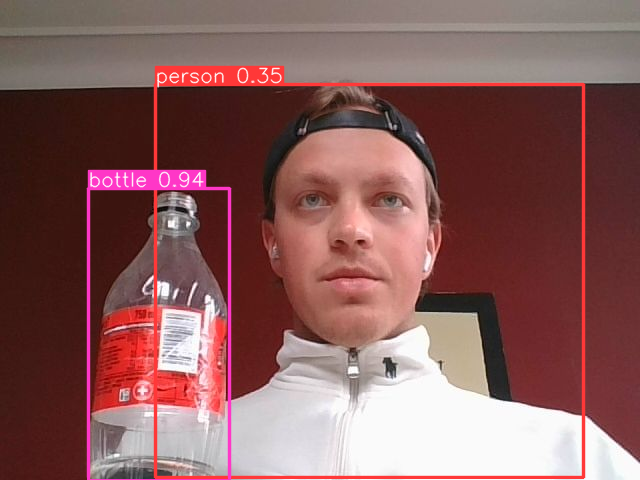

In [ ]:
# illustration of the model on webcam
img, labels, cord_thres = take_photo('photo.jpg')
cv2_imshow(img)

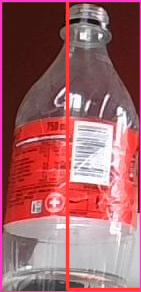

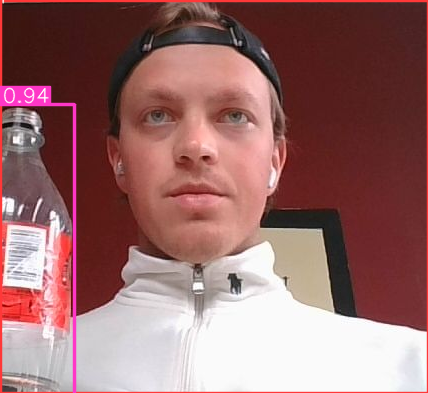

In [ ]:
# cropping out the boundary box for action recognition
x_shape, y_shape = 640, 480
x1 = [int(cord_thres[i][0]*x_shape) for i in range(cord_thres.shape[0])]
x2 = [int(cord_thres[i][2]*x_shape) for i in range(cord_thres.shape[0])]
y1 = [int(cord_thres[i][1]*y_shape) for i in range(cord_thres.shape[0])]
y2 = [int(cord_thres[i][3]*y_shape) for i in range(cord_thres.shape[0])]

imgs_cropped = np.array([])
for i in range(len(x1)):
  img_temp = img[y1[i]:y2[i], x1[i]:x2[i],:]
  cv2_imshow(img_temp)

In [19]:
def trigger(frame, cord_thres, labels, confidence=0.25, x_shape=640, y_shape=480, margin=0.01, centered=True, center_margin=0.1):
  """Function for idetnfying if the trigger condition is satisified. 
  The condition is that a bottle is identified inside the boundary box of a human
  
  input
  ----------
  frame: a frame from a video
  cord_thres: a numpy array of x and y coordinates for the boundary box and a confidence level
  labels: the label of the boundary boxes
  confidence: float in [0,1] specifying how confident the detection must be to allow for trigger
  x_shape: images width
  y_shape: image height
  margin: the margin which a bottle can be outside a human and still fullfil the trigger
  centered: boolean telling if the function should trigger only when the bottle is directly in front of the human
  center_margin: The margin which should be used for center if centered=True
  
  returns:
  triggered: boolean variable telling if the trigger is met
  human: the boundary box for the human that satisfies the trigger"""

  # extracting x and y coordinates for all identified objects
  x1 = [int(cord_thres[i][0]*x_shape) for i in range(cord_thres.shape[0])]
  x2 = [int(cord_thres[i][2]*x_shape) for i in range(cord_thres.shape[0])]
  y1 = [int(cord_thres[i][1]*y_shape) for i in range(cord_thres.shape[0])]
  y2 = [int(cord_thres[i][3]*y_shape) for i in range(cord_thres.shape[0])]

  # the indices of bottles and humans
  bottle_idx = np.where(labels==39)
  human_idx = np.where(labels==0)

  # intializing return variables
  human = None # the boundary box for the human which should be tracked
  triggered = False # boolean specifying if the model is triggered or not

  # checking for every bottle if its inside a human's boundary box
  for bottle in cord_thres[bottle_idx]:
    if bottle[4]<confidence:
      continue
    for human in cord_thres[human_idx]:
      if human[4]<confidence:
        continue
      if (bottle[0]+margin>human[0]) and (bottle[1]+margin>human[1]) and (bottle[2]-margin<human[2]) and (bottle[3]-margin<human[3]):
        # setting triggered to true if the trigger condition is met
        if centered:
          # checking if the bottle is in the center of the human bbox
          center = is_centered(bottle, human, center_margin)
          if center:
            triggered=True
            break
        else:
          triggered=True
          break

  return triggered, human

def is_centered(bottle, human, center_margin):
  """ function for determining whether the bottle is in the center of the human.
  The function returns true if the bottle plus the margin includes the center
  of the human bonudary box.

  input:
  --------------
  bottle: the coordinates of the bottle
  human: the coordinates of the human
  center_margin: the desired margin

  output:
  boolean specifying if the bottle is in the center of the human bbox
  """
  center_x, center_y = (human[0]+human[2])/2, (human[1]+human[3])/2
  b_x1, b_x2, b_y1, b_y2 = bottle[0]-center_margin, bottle[2]+center_margin, bottle[3]-center_margin, bottle[4]+center_margin

  if (center_x>b_x1) and (center_x<b_x2) and (center_y>b_y1) and (center_y<b_y2):
    return True
  else:
    return False


## Testing inference speed
This part testes the inference speed of our chosen model. It also compares the speed between three variants of yolov5: nano, small, and medium. This help us identify the correct trade-off between accuracy and inference speed. The tests are run on cpu as this is most relevant for the processor capabilities of the Loomo robots.

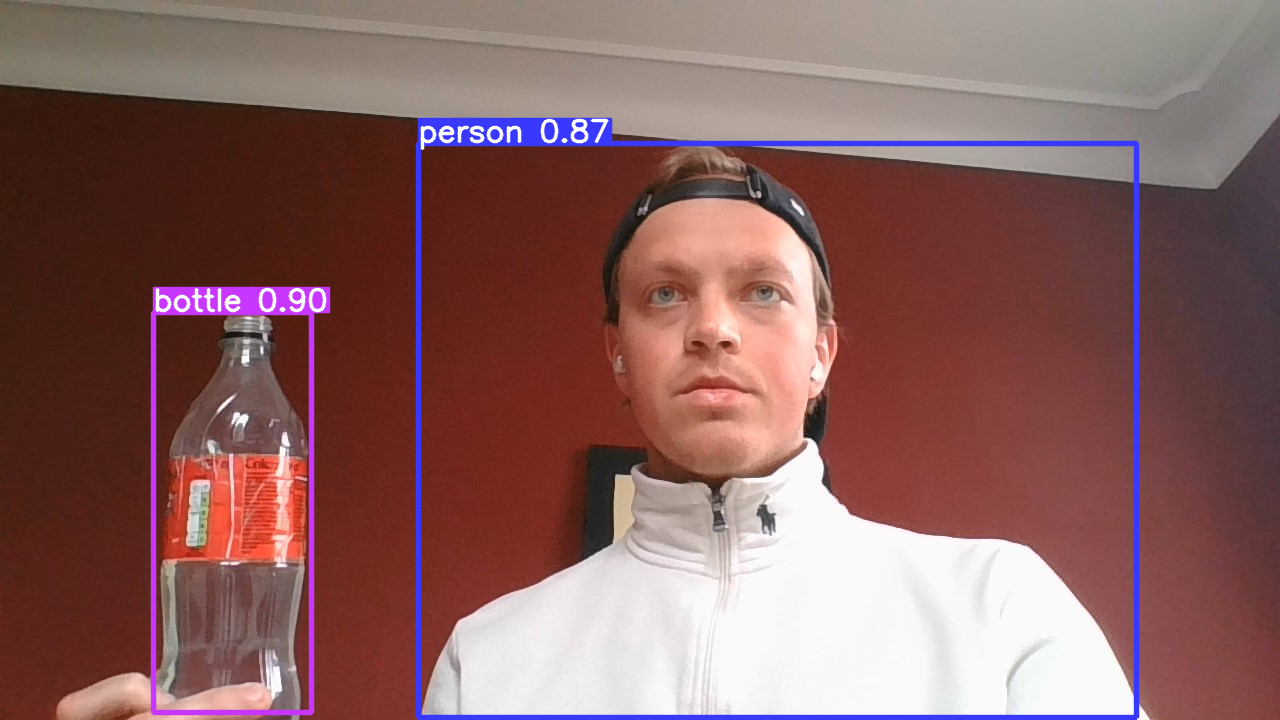

In [ ]:
img_path = '/content/drive/MyDrive/test.jpg'
img = cv2.imread(img_path)
results = model(img)
results.show()
# formatting image for opencv
result = results.imgs[0]
cv2_imshow(result)

In [ ]:
# loading the small model
model_small = torch.hub.load('ultralytics/yolov5', 'yolov5s')
model_small.classes=[0,39]

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-157-g7043872 torch 1.10.0+cu111 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
Adding AutoShape... 


In [ ]:
# loading the nano model
model_nano = torch.hub.load('ultralytics/yolov5', 'yolov5n')
model_nano.classes=[0,39]

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-157-g7043872 torch 1.10.0+cu111 CPU

Fusing layers... 
YOLOv5n summary: 213 layers, 1867405 parameters, 0 gradients, 4.5 GFLOPs
Adding AutoShape... 


In [ ]:
# loading the medium model
model_medium = torch.hub.load('ultralytics/yolov5', 'yolov5m')
model_medium.classes=[0,39]

Using cache found in /root/.cache/torch/hub/ultralytics_yolov5_master
requirements: PyYAML>=5.3.1 not found and is required by YOLOv5, attempting auto-update...

requirements: 1 package updated per /content/yolov5/requirements.txt
requirements: ⚠️ Restart runtime or rerun command for updates to take effect

YOLOv5 🚀 v6.1-157-g7043872 torch 1.10.0+cu111 CPU

Fusing layers... 
YOLOv5m summary: 290 layers, 21172173 parameters, 0 gradients, 49.0 GFLOPs
Adding AutoShape... 


Speed for the small model

In [ ]:
%%timeit -r 5 -n 10
model_small(img)

10 loops, best of 5: 268 ms per loop


Speed for the nano model

In [ ]:
%%timeit -r 5 -n 10
model_nano(img)

10 loops, best of 5: 122 ms per loop


Speed for the medium model

In [ ]:
%%timeit -r 5 -n 10
model_medium(img)

10 loops, best of 5: 665 ms per loop


We observe that the difference is about three in speed from nano to small and small to medium. 

 Currently, we believe we are going to use the small model as the inference speed is solid while having strong accuracy.

This if further strengthed by the following results from Yolov5:

Source(https://github.com/ultralytics/yolov5)

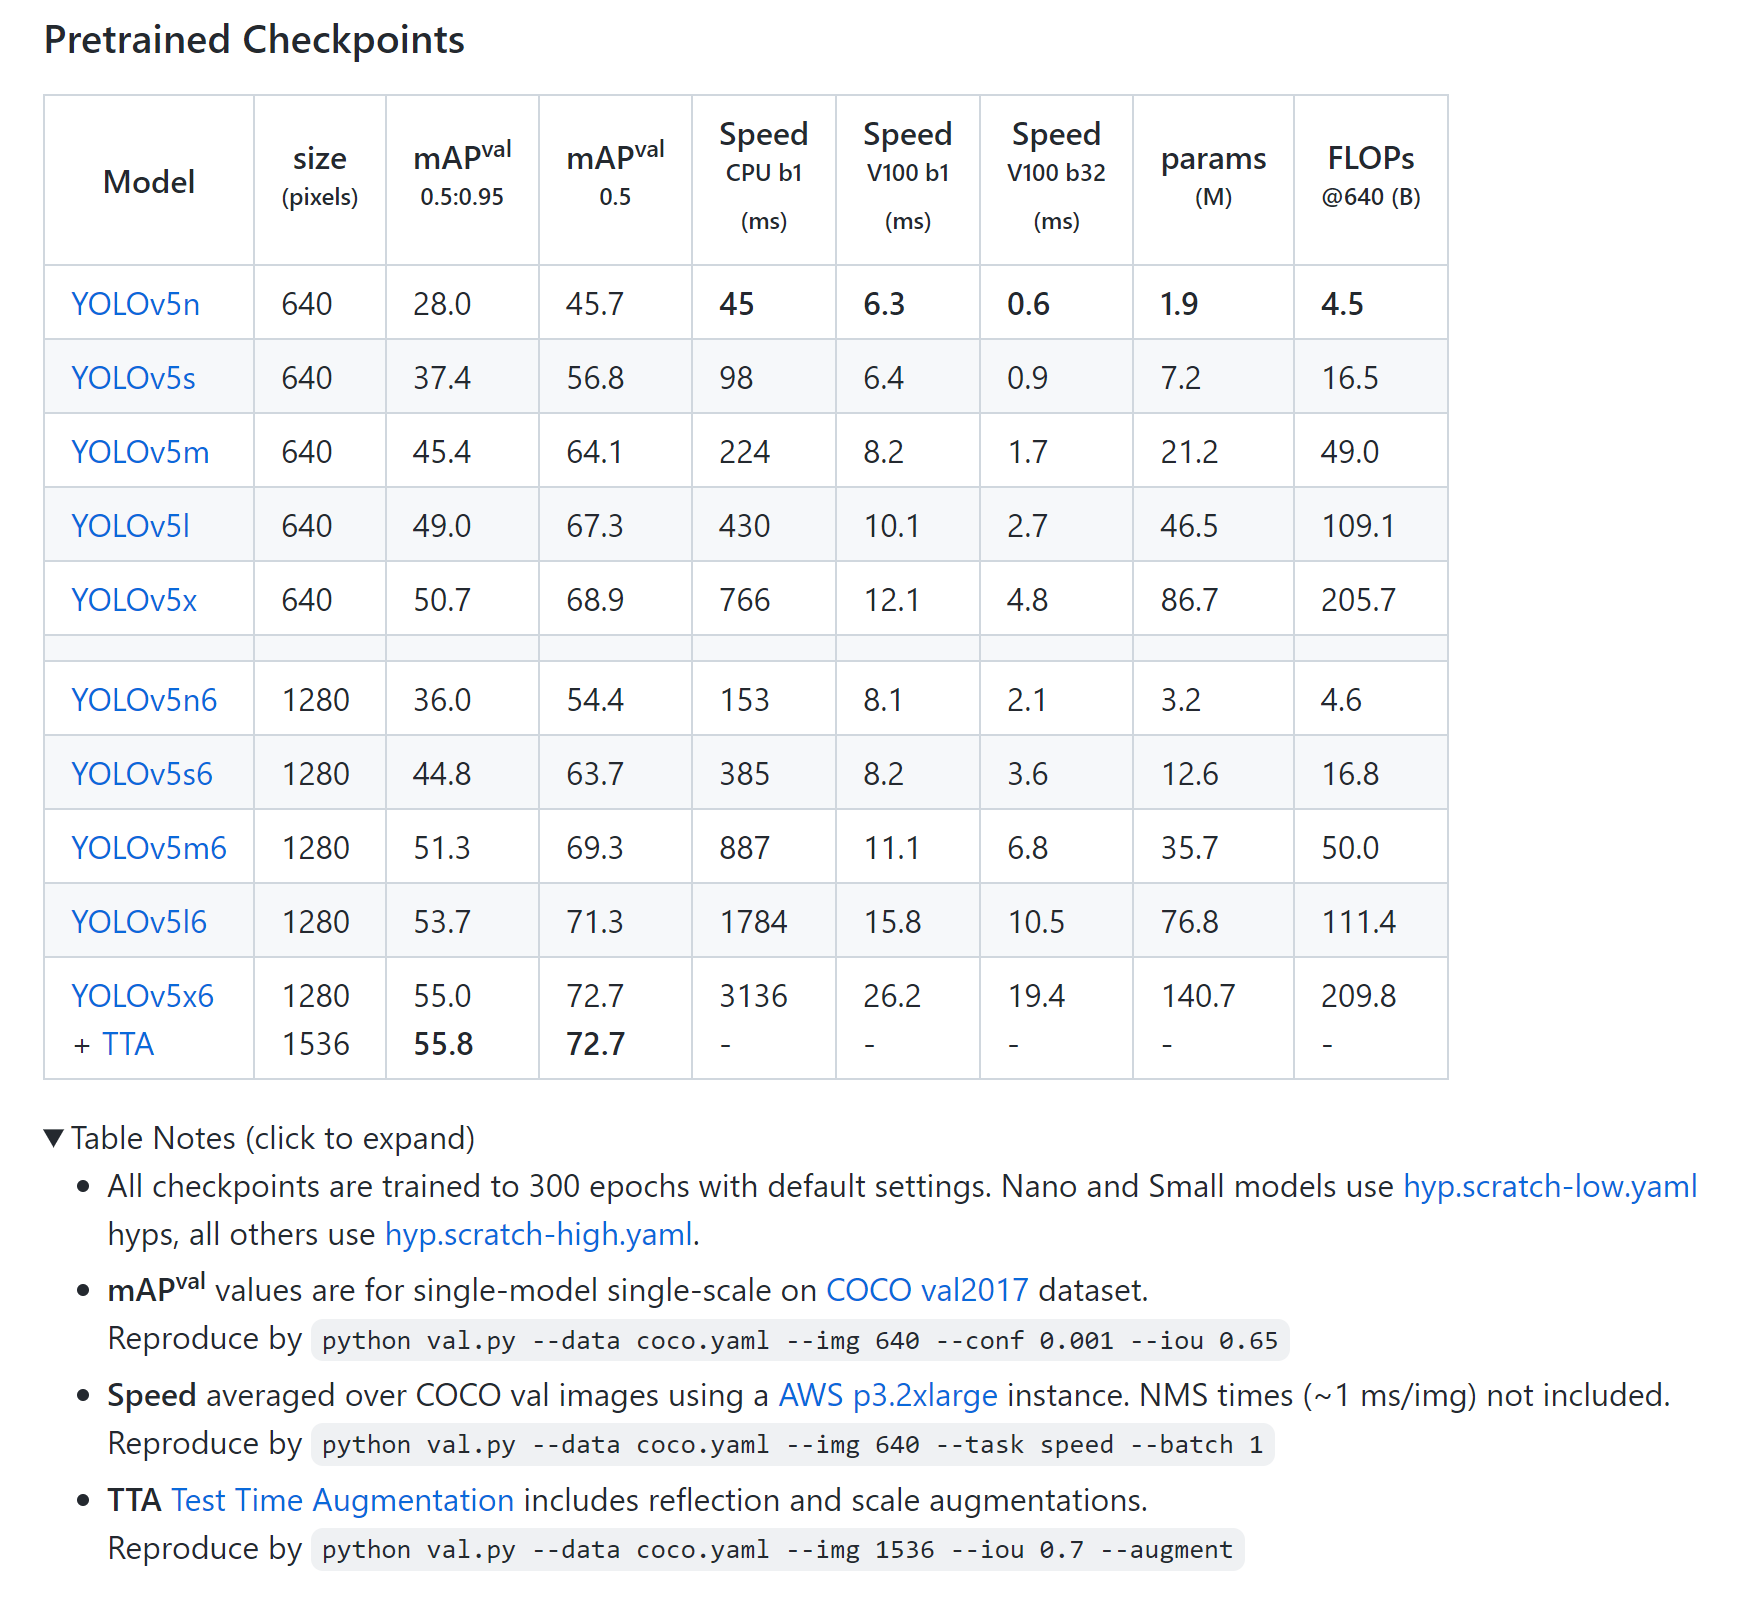

In [ ]:
## calculating the speed of the final model + trigger check
%%timeit -r 5 -n 10
results = model(img)
labels, cord_thres = results.xyxyn[0][:, -1].cpu().numpy(), results.xyxyn[0][:, :-1].cpu().numpy()
triggered, box = trigger(img, cord_thres, labels, x_shape=img.shape[0], y_shape=img.shape[1])

10 loops, best of 5: 91.4 ms per loop


## Webcam video

Code for capturing video with the webcam

In [10]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display.display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

## Applying the model to real-time detection on webcam video

In [22]:
# dictionary for converting class label to readable name
dict_a = {'0':'Human', '39':'Bottle'}
label_html = 'Capturing...'

# initializing variables
bbox = '' # the bounding box which will be drawn on the next frame
triggered = False #boolean specifying if the trigger condition is met
bgr = (0, 255, 0)
x_shape, y_shape = 640, 480 # image shape
wait_cnt = 0 # counter determining wait time for reinitalization

# start streaming video from webcam
video_stream()
while True:
    # extracting frame
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response frame to OpenCV Image
    frame = js_to_image(js_reply["img"])[..., ::-1]

    # this code runs if the person in not initialized yet
    if not triggered:
      # running the frame through the model
      results = model(frame)
      # extracting labels and coordinates of detected objects
      labels, cord_thres = results.xyxyn[0][:, -1].numpy(), results.xyxyn[0][:, :-1].numpy()
      
      # checking for the initalization trigger
      triggered, box = trigger(frame, cord_thres, labels, center_margin = 0.2, confidence=0.25)

      # emptying the bbox
      bbox_array = np.zeros([480,640,4], dtype=np.uint8)
      n = len(labels)

    # runs if the trigger is initiated and the waiting time for reinitalization is not reached yet
    if triggered and wait_cnt<10:
      # drawing the boundary box of the person
      bbox_array = cv2.rectangle(bbox_array, (int(box[0]*x_shape), int(box[1]*y_shape)), (int(box[2]*x_shape), int(box[3]*y_shape)), bgr, 2)
      # adding text specifying that the trigger is initalized
      cv2.putText(bbox_array, 'Initialization succesful', (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2)
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes
      # incrementing the wait counter to reach reinitalization
      wait_cnt+=1

    # reinitalize
    elif wait_cnt>9:
      triggered=False
      wait_cnt=0
    
    # creating boundary boxes for all the identified objets
    else:
      # iterating over identified objects
      for i in range(n):
          # row is the coordinates for the ith object
          row = cord_thres[i]

          # only drawing box if the confidence of the identified object is above 20%
          if row[4] >= 0.2:
              x1, y1, x2, y2 = int(row[0]*x_shape), int(row[1]*y_shape), int(row[2]*x_shape), int(row[3]*y_shape)
              # adding bounding box for the person
              bbox_array = cv2.rectangle(bbox_array, (x1, y1), (x2, y2), bgr, 2)
              # adding text with class and confidence score
              cv2.putText(bbox_array, '%s: %.2f'%(dict_a.get(str(int(labels[i]))) ,row[4]), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.9, bgr, 2)
      bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
      # convert overlay of bbox into bytes
      bbox_bytes = bbox_to_bytes(bbox_array)
      # update bbox so next frame gets new overlay
      bbox = bbox_bytes

<IPython.core.display.Javascript object>